# step 1: merge dataframes

In [1]:
import tools
import glob
import pandas as pd
ls_files = glob.glob("annotated_data/gesture/*")

In [2]:
column_names = pd.read_csv(ls_files[0], delimiter = ',').drop('Unnamed: 0', axis = 1).columns

In [3]:
# create master df by reading each file, then reassembling

import pandas as pd
import numpy as np

ls_df = map(lambda x: pd.read_csv(x, delimiter=','), ls_files)
df = pd.DataFrame(np.vstack(ls_df)).drop(0, axis = 1)
df.columns = column_names

In [4]:
# drop gyro data

df = df.drop(['gyroX', 'gyroY','gyroZ'], axis = 1)

In [5]:
df.shape

(189751, 106)

# step 2: preprocessing

treat missing values.

### 2a) remove "non-events"

if non-events are not removed, no clean boundary will be created.

In [6]:
# df_events = df
df_events = df[df['label'] != "none"].reset_index().drop('index', axis = 1)
df_events.shape

(9790, 106)

In [7]:
# replace infinity with nan - that way we can drop nan's

df_events = df_events.replace([np.inf, -np.inf], np.nan)

In [8]:
# fill in missing entries with its preceding value

df_events_filled = df_events.fillna(method='ffill').dropna().reset_index().drop('index', axis = 1)
df_events_filled.shape

(9782, 106)

In [9]:
X = df_events_filled.drop(['ts','label', 'corresponding_file'], axis = 1)
y = df_events_filled['label']
X.shape, y.shape

((9782, 103), (9782,))

In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape

((7825, 103), (7825,))

### 2b) data visualization

#### view in 2d space

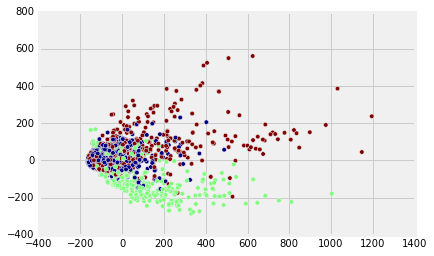

In [11]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_test)

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

le = LabelEncoder()
y_test_factor = le.fit_transform(y_test)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = y_test_factor)

#### view correlation map

/Users/Vincent/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/Vincent/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


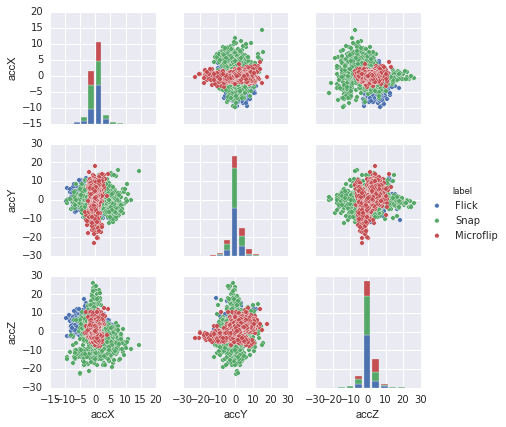

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.pairplot(df_events_filled, vars=['accX', 'accY', 'accZ'], hue='label', size=2)

# 3) model evaluation

## 3a) random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(min_samples_split=50)


In [44]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
clf = model_rf.estimators_[0]

In [57]:
from sklearn.externals.six import StringIO
from sklearn import tree
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [45]:
from sklearn.metrics import confusion_matrix

pred_rf = model_rf.predict(X_test)
confusion_matrix(y_test, pred_rf)

array([[776,   1,  47],
       [  6, 417,  13],
       [ 78,   1, 618]])

In [46]:
y_test.value_counts()

Flick        824
Snap         697
Microflip    436
Name: label, dtype: int64

In [49]:
from sklearn.metrics import classification_report
print classification_report(y_test, pred_rf)

             precision    recall  f1-score   support

      Flick       0.90      0.94      0.92       824
  Microflip       1.00      0.96      0.98       436
       Snap       0.91      0.89      0.90       697

avg / total       0.93      0.93      0.93      1957



### inspect for overfitting

In [19]:
y_factor = le.fit_transform(y)

In [20]:
X.shape

(9782, 103)

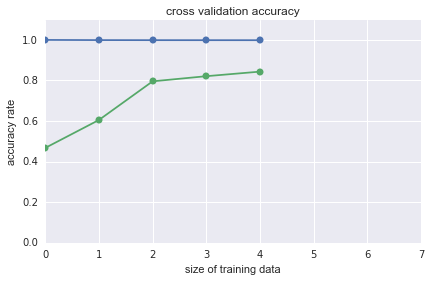

In [21]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(model_rf, X, y_factor, train_sizes=[1000, 3000, 5000, 6000, 6400], cv=5)
plt.plot(map(lambda x: x.mean(), train_scores), marker = 'o')
plt.plot(map(lambda x: x.mean(), valid_scores), marker = 'o')
plt.ylim(0, 1.1)
plt.xlim(0, 7)
plt.xlabel("size of training data")
plt.ylabel("accuracy rate")
plt.title("cross validation accuracy")

In [22]:
from sklearn.externals import joblib
model_rf.fit(X, y)
joblib.dump(model_rf, 'models/gesture_filter/gesture_filter_rf.pkl') 

['models/gesture_filter/gesture_filter_rf.pkl',
 'models/gesture_filter/gesture_filter_rf.pkl_01.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_02.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_03.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_04.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_05.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_06.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_07.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_08.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_09.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_10.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_11.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_12.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_13.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_14.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_15.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_16.npy',
 'models/gesture_filter/gesture_filter_rf.pkl_17.npy',
 'models/gesture_

### identify important features

In [23]:
importance = model_rf.feature_importances_
important_features = np.argsort(importance)[::-1][:10]

for idx in important_features:
    print X.columns[idx], importance[idx]
    print '-' * 10

magnitude_energy 0.0662445279574
----------
time_gravity_accX_mean 0.0398856009082
----------
gravY 0.036196310477
----------
time_body_accZ_min 0.0314161543825
----------
gravity_magnitude_energy 0.0297153400367
----------
time_gravity_accY_std 0.0290510208689
----------
magnitude 0.0268869844563
----------
time_gravity_accY_mean 0.0265364895547
----------
time_grav_magnitude_mean 0.0254231540039
----------
time_body_accY_jerk_mean 0.0239930520305
----------


## 3b) neural network

## 3c) gradient boosted trees

### 3d) SVM

In [24]:
from sklearn import svm
model_svm = svm.SVC(kernel = 'rbf')
from sklearn.metrics import confusion_matrix

model_svm.fit(X_train, y_train)
pred_svm = model_svm.predict(X_test)

confusion_matrix(y_test, pred_svm)

array([[525,   0, 299],
       [  5,  70, 361],
       [ 73,   1, 623]])

In [25]:
from sklearn.metrics import classification_report
print classification_report(y_test, pred_svm)

             precision    recall  f1-score   support

      Flick       0.87      0.64      0.74       824
  Microflip       0.99      0.16      0.28       436
       Snap       0.49      0.89      0.63       697

avg / total       0.76      0.62      0.60      1957



### 3e) logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l1')
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

confusion_matrix(y_test, pred_lr)

array([[700,   1, 123],
       [  6, 426,   4],
       [148,   5, 544]])

In [27]:
print classification_report(y_test, pred_lr)

             precision    recall  f1-score   support

      Flick       0.82      0.85      0.83       824
  Microflip       0.99      0.98      0.98       436
       Snap       0.81      0.78      0.80       697

avg / total       0.85      0.85      0.85      1957



In [28]:
model_lr.fit(X, y)
joblib.dump(model_lr, 'models/gesture_filter/gesture_filter_lr.pkl') 

['models/gesture_filter/gesture_filter_lr.pkl',
 'models/gesture_filter/gesture_filter_lr.pkl_01.npy',
 'models/gesture_filter/gesture_filter_lr.pkl_02.npy',
 'models/gesture_filter/gesture_filter_lr.pkl_03.npy',
 'models/gesture_filter/gesture_filter_lr.pkl_04.npy']